# Multi-seed Grokking Results Visualization

This notebook visualizes results from multi-seed grokking experiments with:
- **Plot 1**: Accuracy + LLC × L2 Norm (dual y-axis)
- **Plot 2**: Loss + LLC × L2 Norm (dual y-axis)

All plots show mean ± range over multiple seeds.
- Main curves: Training & Test metrics
- Green dashed line (right axis): LLC × L2 Norm (product of LLC complexity and L2 parameter norm)


In [25]:
import os
import csv
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path


In [26]:
# Configuration
DATA_DIR = "/root/data1/zjj/ICML2026/grokking_full_parallel_1210_2057"
OUTPUT_DIR = "L2*LLC"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Set matplotlib style for publication-quality plots
plt.rcParams.update({
    'font.size': 11,
    'font.family': 'serif',
    'axes.labelsize': 12,
    'axes.titlesize': 13,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'legend.fontsize': 10,
    'figure.titlesize': 14,
    'axes.linewidth': 1.2,
    'grid.linewidth': 0.8,
    'lines.linewidth': 2.0,
})


In [27]:
def load_seed_data(csv_path):
    """Load metrics from a single seed CSV file."""
    metrics = {'steps': [], 'train_loss': [], 'train_acc': [], 'test_loss': [], 'test_acc': [], 'llc': [], 'l2_norm': []}
    
    with open(csv_path, 'r') as f:
        reader = csv.DictReader(f)
        for row in reader:
            metrics['steps'].append(int(row['steps']))
            metrics['train_loss'].append(float(row['train_loss']))
            metrics['train_acc'].append(float(row['train_acc']))
            metrics['test_loss'].append(float(row['test_loss']))
            metrics['test_acc'].append(float(row['test_acc']))
            
            # Handle NaN values in LLC
            llc_val = row['llc']
            if llc_val == 'nan' or llc_val == '':
                metrics['llc'].append(np.nan)
            else:
                metrics['llc'].append(float(llc_val))
            
            # Load L2 norm (handle missing column for backward compatibility)
            if 'l2_norm' in row:
                metrics['l2_norm'].append(float(row['l2_norm']))
            else:
                metrics['l2_norm'].append(np.nan)
    
    return metrics


def load_task_data(task_dir, wd):
    """Load all seed data for a specific task and weight decay."""
    wd_dir = os.path.join(task_dir, f"wd_{wd}")
    
    if not os.path.exists(wd_dir):
        return None
    
    all_metrics = []
    for seed_file in sorted(os.listdir(wd_dir)):
        if seed_file.endswith('.csv'):
            csv_path = os.path.join(wd_dir, seed_file)
            metrics = load_seed_data(csv_path)
            all_metrics.append(metrics)
    
    return all_metrics if all_metrics else None


In [28]:
def plot_with_llc(all_metrics, task_name, wd, save_dir):
    """Plot accuracy and loss with LLC × L2 overlay (dual y-axis for each plot)."""
    
    # Get common steps
    common_steps = all_metrics[0]['steps']
    
    # Compute statistics for each metric
    def compute_stats(key):
        data = np.array([m[key] for m in all_metrics])  # shape: (n_seeds, n_steps)
        mean = np.mean(data, axis=0)
        std = np.std(data, axis=0)
        lower = np.min(data, axis=0)
        upper = np.max(data, axis=0)
        return mean, lower, upper
    
    train_acc_mean, train_acc_lower, train_acc_upper = compute_stats('train_acc')
    test_acc_mean, test_acc_lower, test_acc_upper = compute_stats('test_acc')
    train_loss_mean, train_loss_lower, train_loss_upper = compute_stats('train_loss')
    test_loss_mean, test_loss_lower, test_loss_upper = compute_stats('test_loss')
    l2_mean, l2_lower, l2_upper = compute_stats('l2_norm')
    
    # Process LLC data (filter NaN values)
    llc_data = np.array([m['llc'] for m in all_metrics])
    llc_mean = np.nanmean(llc_data, axis=0)
    llc_std = np.nanstd(llc_data, axis=0)
    llc_lower = np.nanmin(llc_data, axis=0)
    llc_upper = np.nanmax(llc_data, axis=0)
    
    # Compute LLC × L2 product
    llc_times_l2_data = np.array([m['llc'] for m in all_metrics]) * np.array([m['l2_norm'] for m in all_metrics])
    llc_times_l2_mean = np.nanmean(llc_times_l2_data, axis=0)
    llc_times_l2_lower = np.nanmin(llc_times_l2_data, axis=0)
    llc_times_l2_upper = np.nanmax(llc_times_l2_data, axis=0)
    
    # Filter valid LLC steps
    valid_mask = ~np.isnan(llc_mean)
    llc_steps = np.array(common_steps)[valid_mask]
    llc_times_l2_mean_valid = llc_times_l2_mean[valid_mask]
    llc_times_l2_lower_valid = llc_times_l2_lower[valid_mask]
    llc_times_l2_upper_valid = llc_times_l2_upper[valid_mask]
    
    # Color scheme
    colors = {
        'train': '#1f77b4',  # Blue
        'test': '#d62728',   # Red
        'llc_l2': '#2ca02c',    # Green
    }
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    
    # ===== Plot 1: Accuracy + LLC × L2 (dual y-axis) =====
    ax1_llc_l2 = ax1.twinx()
    
    # Plot Accuracy
    ax1.fill_between(common_steps, train_acc_lower, train_acc_upper, 
                     color=colors['train'], alpha=0.2, linewidth=0)
    ax1.plot(common_steps, train_acc_mean, label='Train Acc', 
             color=colors['train'], linewidth=2, alpha=0.9)
    
    ax1.fill_between(common_steps, test_acc_lower, test_acc_upper, 
                     color=colors['test'], alpha=0.2, linewidth=0)
    ax1.plot(common_steps, test_acc_mean, label='Test Acc', 
             color=colors['test'], linewidth=2.5, alpha=0.95)
    
    ax1.set_xlabel('Training Steps', fontweight='medium')
    ax1.set_ylabel('Accuracy', fontweight='medium')
    ax1.set_xscale('log')
    ax1.set_ylim([-0.05, 1.05])
    ax1.grid(True, alpha=0.25, linestyle='--')
    
    # Plot LLC × L2 on right y-axis
    if len(llc_steps) > 0:
        ax1_llc_l2.fill_between(llc_steps, llc_times_l2_lower_valid, llc_times_l2_upper_valid, 
                             color=colors['llc_l2'], alpha=0.15, linewidth=0)
        ax1_llc_l2.plot(llc_steps, llc_times_l2_mean_valid, label='Complexity', 
                     color=colors['llc_l2'], linewidth=2, linestyle='--', alpha=0.8)
        ax1_llc_l2.set_ylabel('Complexity', color=colors['llc_l2'], fontweight='medium')
        ax1_llc_l2.tick_params(axis='y', labelcolor=colors['llc_l2'])
        ax1_llc_l2.set_xscale('log')
    
    # Legend at bottom (horizontal layout)
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax1_llc_l2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, 
              loc='upper center', bbox_to_anchor=(0.5, -0.12), 
              ncol=3, frameon=True, fancybox=True, shadow=False, 
              edgecolor='gray', framealpha=0.95)
    
    # ===== Plot 2: Loss + LLC × L2 (dual y-axis) =====
    ax2_llc_l2 = ax2.twinx()
    
    # Plot Loss
    ax2.fill_between(common_steps, train_loss_lower, train_loss_upper, 
                     color=colors['train'], alpha=0.2, linewidth=0)
    ax2.plot(common_steps, train_loss_mean, label='Train Loss', 
             color=colors['train'], linewidth=2, alpha=0.9)
    
    ax2.fill_between(common_steps, test_loss_lower, test_loss_upper, 
                     color=colors['test'], alpha=0.2, linewidth=0)
    ax2.plot(common_steps, test_loss_mean, label='Test Loss', 
             color=colors['test'], linewidth=2.5, alpha=0.95)
    
    ax2.set_xlabel('Training Steps', fontweight='medium')
    ax2.set_ylabel('Loss', fontweight='medium')
    ax2.set_xscale('log')
    ax2.set_yscale('log')
    ax2.grid(True, alpha=0.25, linestyle='--')
    
    # Plot LLC × L2 on right y-axis
    if len(llc_steps) > 0:
        ax2_llc_l2.fill_between(llc_steps, llc_times_l2_lower_valid, llc_times_l2_upper_valid, 
                             color=colors['llc_l2'], alpha=0.15, linewidth=0)
        ax2_llc_l2.plot(llc_steps, llc_times_l2_mean_valid, label='Complexity', 
                     color=colors['llc_l2'], linewidth=2, linestyle='--', alpha=0.8)
        ax2_llc_l2.set_ylabel('Complexity', color=colors['llc_l2'], fontweight='medium')
        ax2_llc_l2.tick_params(axis='y', labelcolor=colors['llc_l2'])
        ax2_llc_l2.set_xscale('log')
    
    # Legend at bottom (horizontal layout)
    lines1, labels1 = ax2.get_legend_handles_labels()
    lines2, labels2 = ax2_llc_l2.get_legend_handles_labels()
    ax2.legend(lines1 + lines2, labels1 + labels2, 
              loc='upper center', bbox_to_anchor=(0.5, -0.12), 
              ncol=3, frameon=True, fancybox=True, shadow=False, 
              edgecolor='gray', framealpha=0.95)
    
    # Title
    plt.suptitle(f"Task: {task_name} | WD: {wd} | (Mean ± Range over 3 seeds)", 
                 fontsize=14, y=0.98)
    
    plt.tight_layout(rect=[0, 0.05, 1.0, 0.96])  # Leave space for legend and title
    
    # Save with legal filename (replace superscript characters)
    safe_task_name = (task_name.replace('/', '_div_')
                                .replace('*', '_mul_')
                                .replace('+', '_plus_')
                                .replace('²', '2')
                                .replace('³', '3')
                                .replace('-', '_minus_'))
    output_path = os.path.join(save_dir, f"{safe_task_name}_wd{wd}.png")
    plt.savefig(output_path, dpi=300, bbox_inches='tight')
    plt.close()
    
    print(f"✓ Saved: {output_path}")


In [29]:
# Define tasks and weight decays
tasks = [
    ('x_plus_y', 'x+y'),
    ('x-y', 'x-y'),
    ('x_mul_y', 'x*y'),
    ('x_div_y', 'x/y'),
    ('x2_plus_y2', 'x2+y2'),
    ('x2_plus_xy_plus_y2', 'x2+xy+y2'),
    ('x2_plus_xy_plus_y2_plus_x', 'x2+xy+y2+x'),
    ('x3_plus_xy', 'x3+xy'),
    ('x3_plus_xy2_plus_y', 'x3+xy2+y')
]

weight_decays = [0.0, 1.0]


In [30]:
# Generate all plots
print("="*60)
print("Generating plots with LLC overlay...")
print("="*60)

for task_dir, task_display in tasks:
    task_path = os.path.join(DATA_DIR, task_dir)
    
    if not os.path.exists(task_path):
        print(f"⚠ Skipping {task_display}: directory not found")
        continue
    
    for wd in weight_decays:
        all_metrics = load_task_data(task_path, wd)
        
        if all_metrics is None or len(all_metrics) == 0:
            print(f"⚠ No data for {task_display} WD={wd}")
            continue
        
        plot_with_llc(all_metrics, task_display, wd, OUTPUT_DIR)

print("\n" + "="*60)
print(f"All plots saved to: {OUTPUT_DIR}/")
print("="*60)


Generating plots with LLC overlay...
✓ Saved: L2*LLC/x_plus_y_wd0.0.png
✓ Saved: L2*LLC/x_plus_y_wd1.0.png
✓ Saved: L2*LLC/x_minus_y_wd0.0.png
✓ Saved: L2*LLC/x_minus_y_wd1.0.png
✓ Saved: L2*LLC/x_mul_y_wd0.0.png
✓ Saved: L2*LLC/x_mul_y_wd1.0.png
✓ Saved: L2*LLC/x_div_y_wd0.0.png
✓ Saved: L2*LLC/x_div_y_wd1.0.png
✓ Saved: L2*LLC/x2_plus_y2_wd0.0.png
✓ Saved: L2*LLC/x2_plus_y2_wd1.0.png
✓ Saved: L2*LLC/x2_plus_xy_plus_y2_wd0.0.png
✓ Saved: L2*LLC/x2_plus_xy_plus_y2_wd1.0.png
✓ Saved: L2*LLC/x2_plus_xy_plus_y2_plus_x_wd0.0.png
✓ Saved: L2*LLC/x2_plus_xy_plus_y2_plus_x_wd1.0.png
✓ Saved: L2*LLC/x3_plus_xy_wd0.0.png
✓ Saved: L2*LLC/x3_plus_xy_wd1.0.png
✓ Saved: L2*LLC/x3_plus_xy2_plus_y_wd0.0.png
✓ Saved: L2*LLC/x3_plus_xy2_plus_y_wd1.0.png

All plots saved to: L2*LLC/



Example plot: x2_plus_xy_plus_y2_plus_x_wd0.0.png


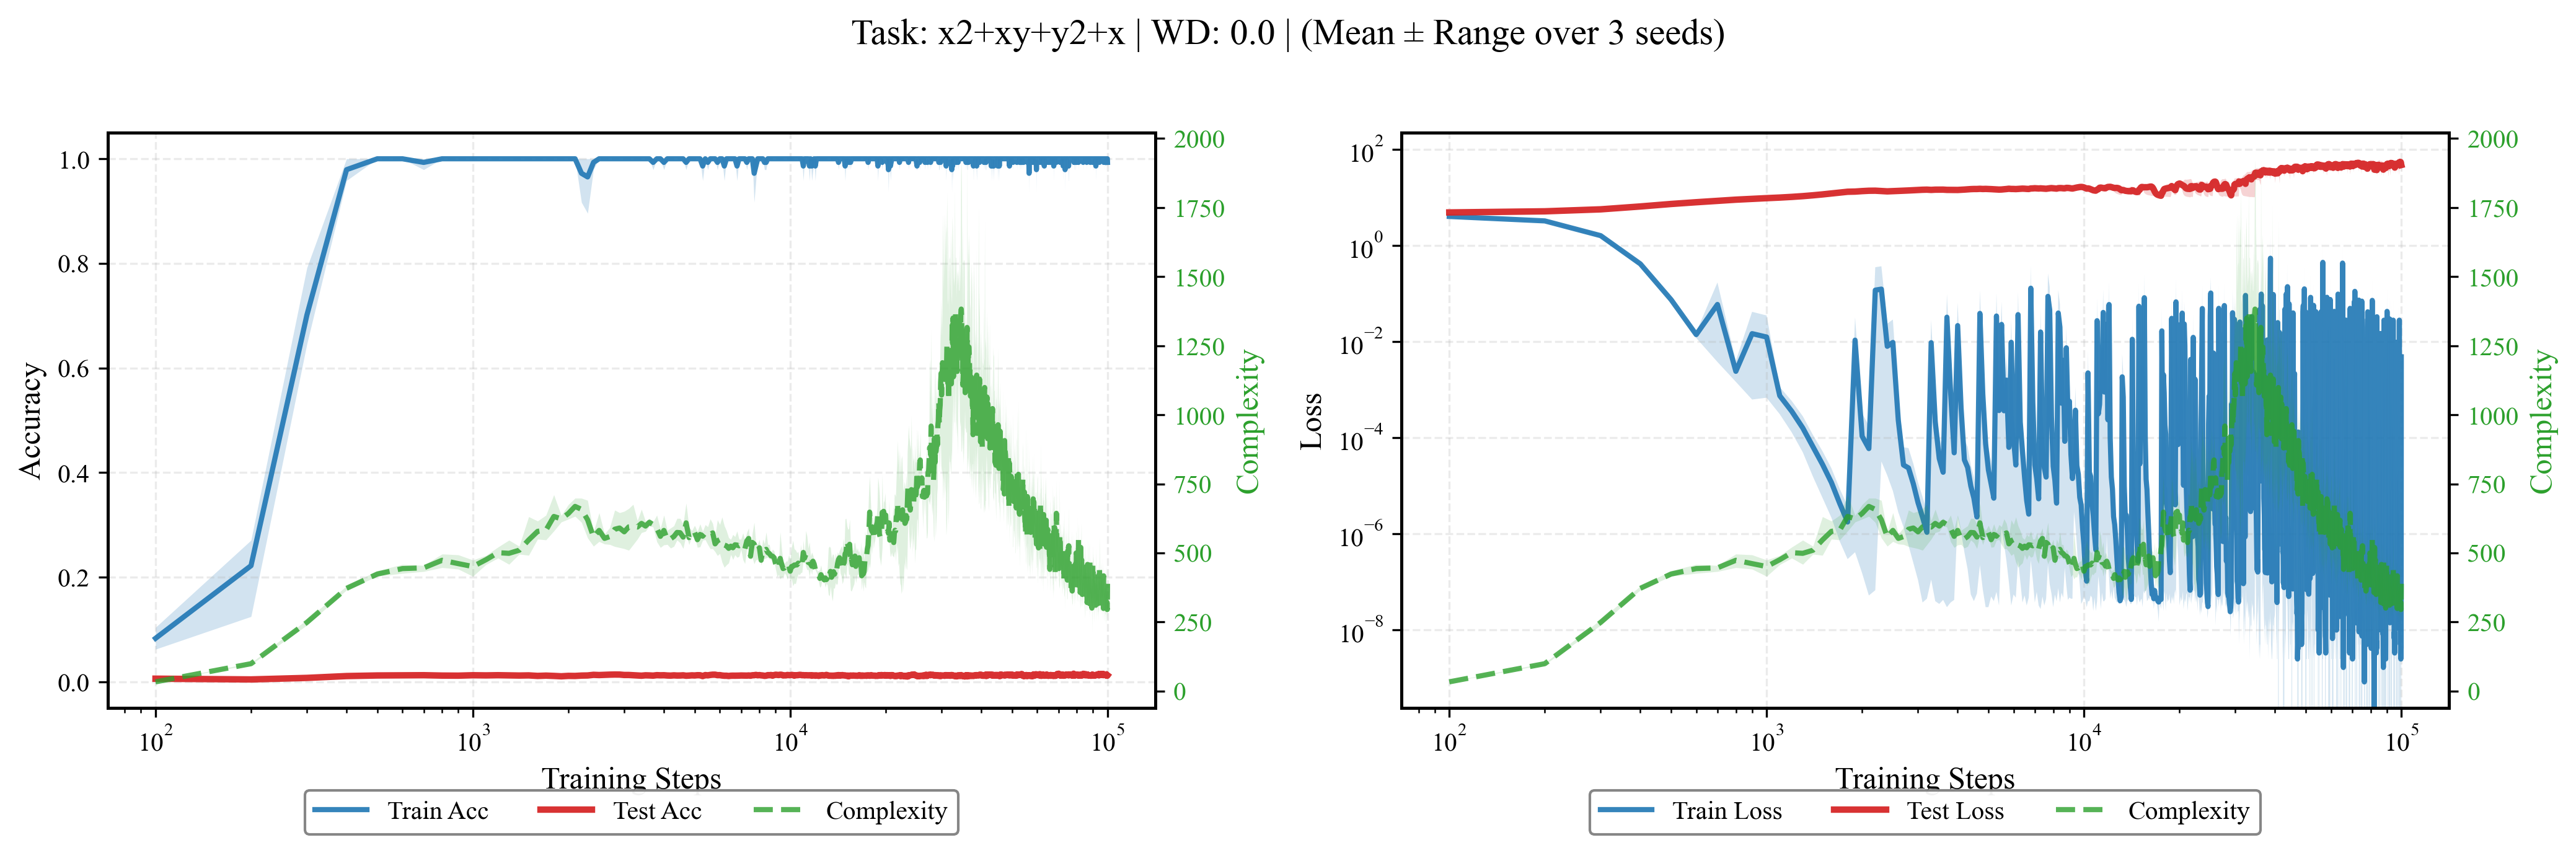

In [31]:
# Optional: Display one example plot
from IPython.display import Image, display

# Show the first generated plot as example
example_plots = sorted([f for f in os.listdir(OUTPUT_DIR) if f.endswith('.png')])
if example_plots:
    print(f"\nExample plot: {example_plots[0]}")
    display(Image(filename=os.path.join(OUTPUT_DIR, example_plots[0])))


In [1]:
"""
合并同一种子的所有step CSV文件
将 seed42_step100.csv, seed42_step200.csv, ... 合并成 seed42.csv
"""
import os
import csv
import glob
from collections import defaultdict
from pathlib import Path

# 设置数据目录
DATA_DIR = "/root/autodl-tmp/test/results/data"

def merge_seed_csvs(data_dir):
    """合并同一种子的所有step CSV文件"""
    
    # 遍历所有任务和weight_decay组合
    for task_dir in Path(data_dir).iterdir():
        if not task_dir.is_dir():
            continue
        
        for wd_dir in task_dir.iterdir():
            if not wd_dir.is_dir():
                continue
            
            print(f"Processing: {task_dir.name}/{wd_dir.name}")
            
            # 收集所有CSV文件，按种子分组
            seed_files = defaultdict(list)
            for csv_file in wd_dir.glob("seed*_step*.csv"):
                # 从文件名提取种子号: seed42_step100.csv -> 42
                filename = csv_file.stem  # seed42_step100
                parts = filename.split('_')
                seed_num = parts[0].replace('seed', '')  # 42
                seed_files[seed_num].append(csv_file)
            
            # 对每个种子进行合并
            for seed_num, files in seed_files.items():
                if not files:
                    continue
                
                # 按step排序
                files.sort(key=lambda f: int(f.stem.split('_step')[1]))
                
                # 读取所有数据
                all_data = []
                header = None
                
                for file in files:
                    with open(file, 'r') as f:
                        reader = csv.DictReader(f)
                        if header is None:
                            header = reader.fieldnames
                        for row in reader:
                            all_data.append(row)
                
                if not all_data:
                    print(f"  Warning: No data for seed {seed_num}")
                    continue
                
                # 写入合并后的文件
                merged_file = wd_dir / f"seed{seed_num}.csv"
                with open(merged_file, 'w', newline='') as f:
                    writer = csv.DictWriter(f, fieldnames=header)
                    writer.writeheader()
                    writer.writerows(all_data)
                
                print(f"  ✓ Merged seed{seed_num}: {len(files)} files -> {len(all_data)} rows")
                
                # 删除原来的单个step文件
                for file in files:
                    file.unlink()
                
                print(f"  ✓ Deleted {len(files)} individual step files")

# 执行合并
print("Starting CSV merging process...")
print("="*60)
merge_seed_csvs(DATA_DIR)
print("="*60)
print("✓ All CSV files merged successfully!")


Starting CSV merging process...
Processing: x_plus_y/wd_0.0
  ✓ Merged seed42: 1000 files -> 1000 rows
  ✓ Deleted 1000 individual step files
  ✓ Merged seed2025: 1000 files -> 1000 rows
  ✓ Deleted 1000 individual step files
Processing: x_plus_y/wd_1.0
  ✓ Merged seed101: 1000 files -> 1000 rows
  ✓ Deleted 1000 individual step files
Processing: x-y/wd_0.0
  ✓ Merged seed42: 1000 files -> 1000 rows
  ✓ Deleted 1000 individual step files
  ✓ Merged seed2025: 1000 files -> 1000 rows
  ✓ Deleted 1000 individual step files
Processing: x-y/wd_1.0
  ✓ Merged seed101: 1000 files -> 1000 rows
  ✓ Deleted 1000 individual step files
Processing: x_mul_y/wd_1.0
  ✓ Merged seed101: 1000 files -> 1000 rows
  ✓ Deleted 1000 individual step files
Processing: x_mul_y/wd_0.0
  ✓ Merged seed2025: 1000 files -> 1000 rows
  ✓ Deleted 1000 individual step files
  ✓ Merged seed42: 1000 files -> 1000 rows
  ✓ Deleted 1000 individual step files
Processing: x2_plus_y2/wd_0.0
  ✓ Merged seed42: 1000 files -> 10

In [2]:
"""
绘制训练过程中的指标变化曲线
包括：训练acc、测试acc、LLC×L2、L2范数、谱熵
- 有2个种子：绘制均值±标准差
- 只有1个种子：绘制单线
"""
import numpy as np
import matplotlib.pyplot as plt
import csv
from pathlib import Path

DATA_DIR = "/root/autodl-tmp/test/results/data"
OUTPUT_DIR = "/root/autodl-tmp/test/results/plots"
os.makedirs(OUTPUT_DIR, exist_ok=True)

def load_seed_data(csv_file):
    """加载单个种子的CSV数据"""
    data = {
        'steps': [],
        'train_acc': [],
        'test_acc': [],
        'llc': [],
        'l2_norm': [],
        'spectral_entropy': []
    }
    
    with open(csv_file, 'r') as f:
        reader = csv.DictReader(f)
        for row in reader:
            data['steps'].append(int(row['step']))
            data['train_acc'].append(float(row['train_acc']))
            data['test_acc'].append(float(row['test_acc']))
            data['llc'].append(float(row['llc']))
            data['l2_norm'].append(float(row['l2_norm']))
            data['spectral_entropy'].append(float(row['spectral_entropy']))
    
    # 计算 LLC × L2
    data['llc_l2'] = [llc * l2 for llc, l2 in zip(data['llc'], data['l2_norm'])]
    
    return data

def plot_metrics(task_name, wd, seeds_data):
    """绘制指标变化图"""
    fig, axes = plt.subplots(1, 5, figsize=(25, 4))
    
    # 获取steps（假设所有种子的steps相同）
    steps = seeds_data[0]['steps']
    num_seeds = len(seeds_data)
    
    # 定义要绘制的指标
    metrics = [
        ('train_acc', 'Training Accuracy', 'blue'),
        ('test_acc', 'Test Accuracy', 'red'),
        ('llc_l2', 'LLC × L2 Norm', 'green'),
        ('l2_norm', 'L2 Norm', 'purple'),
        ('spectral_entropy', 'Spectral Entropy', 'orange')
    ]
    
    for idx, (metric_key, title, color) in enumerate(metrics):
        ax = axes[idx]
        
        # 收集所有种子的数据
        all_values = np.array([seed[metric_key] for seed in seeds_data])
        
        if num_seeds >= 2:
            # 多种子：绘制均值和标准差
            mean_vals = np.mean(all_values, axis=0)
            std_vals = np.std(all_values, axis=0)
            
            ax.plot(steps, mean_vals, color=color, linewidth=2, label='Mean')
            ax.fill_between(steps, mean_vals - std_vals, mean_vals + std_vals, 
                           color=color, alpha=0.2, label='±Std')
            ax.legend()
        else:
            # 单种子：直接绘制
            ax.plot(steps, all_values[0], color=color, linewidth=2)
        
        ax.set_title(title)
        ax.set_xlabel('Training Steps')
        ax.set_xscale('log')
        ax.grid(True, alpha=0.3)
        
        # 对准确率设置y轴范围
        if 'acc' in metric_key:
            ax.set_ylim(-0.05, 1.05)
            ax.set_ylabel('Accuracy')
        else:
            ax.set_ylabel(title)
    
    plt.suptitle(f'{task_name} | Weight Decay: {wd} | Seeds: {num_seeds}', 
                 fontsize=14, y=1.02)
    plt.tight_layout()
    
    # 保存图片
    save_path = Path(OUTPUT_DIR) / f"{task_name}_wd{wd}.png"
    plt.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.close()
    
    print(f"  ✓ Saved: {save_path.name}")

# 遍历所有任务和weight_decay
print("Generating plots...")
print("="*60)

for task_dir in Path(DATA_DIR).iterdir():
    if not task_dir.is_dir():
        continue
    
    task_name = task_dir.name
    
    for wd_dir in task_dir.iterdir():
        if not wd_dir.is_dir():
            continue
        
        wd = wd_dir.name.replace('wd_', '')
        
        # 加载所有种子数据
        seed_files = sorted(wd_dir.glob("seed*.csv"))
        
        if not seed_files:
            print(f"Warning: No seed files in {task_name}/{wd_dir.name}")
            continue
        
        print(f"Processing: {task_name} | WD={wd} | Seeds={len(seed_files)}")
        
        seeds_data = []
        for seed_file in seed_files:
            try:
                data = load_seed_data(seed_file)
                seeds_data.append(data)
            except Exception as e:
                print(f"  Error loading {seed_file.name}: {e}")
        
        if seeds_data:
            plot_metrics(task_name, wd, seeds_data)

print("="*60)
print(f"✓ All plots saved to: {OUTPUT_DIR}")


Generating plots...
Processing: x_plus_y | WD=0.0 | Seeds=2
  ✓ Saved: x_plus_y_wd0.0.png
Processing: x_plus_y | WD=1.0 | Seeds=1
  ✓ Saved: x_plus_y_wd1.0.png
Processing: x-y | WD=0.0 | Seeds=2
  ✓ Saved: x-y_wd0.0.png
Processing: x-y | WD=1.0 | Seeds=1
  ✓ Saved: x-y_wd1.0.png
Processing: x_mul_y | WD=1.0 | Seeds=1
  ✓ Saved: x_mul_y_wd1.0.png
Processing: x_mul_y | WD=0.0 | Seeds=2
  ✓ Saved: x_mul_y_wd0.0.png
Processing: x2_plus_y2 | WD=0.0 | Seeds=2
  ✓ Saved: x2_plus_y2_wd0.0.png
Processing: x2_plus_y2 | WD=1.0 | Seeds=1
  ✓ Saved: x2_plus_y2_wd1.0.png
Processing: x_div_y | WD=0.0 | Seeds=2
  ✓ Saved: x_div_y_wd0.0.png
Processing: x_div_y | WD=1.0 | Seeds=1
  ✓ Saved: x_div_y_wd1.0.png
Processing: x2_plus_xy_plus_y2 | WD=0.0 | Seeds=2
  ✓ Saved: x2_plus_xy_plus_y2_wd0.0.png
Processing: x2_plus_xy_plus_y2 | WD=1.0 | Seeds=1
  ✓ Saved: x2_plus_xy_plus_y2_wd1.0.png
Processing: x2_plus_xy_plus_y2_plus_x | WD=0.0 | Seeds=2
  ✓ Saved: x2_plus_xy_plus_y2_plus_x_wd0.0.png
Processing: x2_p

In [4]:
"""
计算模型权重的Gzip压缩比率，并添加到CSV文件中
压缩比率 = 压缩后大小 / 原始大小（越小表示越可压缩）
"""
import os
import gzip
import torch
import csv
import io
from pathlib import Path
from collections import defaultdict

CHECKPOINT_DIR = "/root/autodl-tmp/test/results/checkpoints"
DATA_DIR = "/root/autodl-tmp/test/results/data"

def calculate_gzip_ratio(checkpoint_path):
    """
    计算模型权重的gzip压缩比率
    返回: 压缩比率 (0-1之间，越小表示越可压缩)
    """
    # 加载checkpoint (PyTorch 2.6+ 需要 weights_only=False)
    checkpoint = torch.load(checkpoint_path, map_location='cpu', weights_only=False)
    model_state = checkpoint['model_state_dict']
    
    # 将模型权重序列化为字节
    buffer = io.BytesIO()
    torch.save(model_state, buffer)
    original_bytes = buffer.getvalue()
    original_size = len(original_bytes)
    
    # Gzip压缩
    compressed_bytes = gzip.compress(original_bytes)
    compressed_size = len(compressed_bytes)
    
    # 计算压缩比率
    compression_ratio = compressed_size / original_size
    
    return compression_ratio, original_size, compressed_size

def add_compression_ratios():
    """遍历所有checkpoint，计算压缩比率并更新CSV"""
    
    print("Computing Gzip compression ratios for model weights...")
    print("="*70)
    
    # 存储每个CSV文件需要更新的数据
    csv_updates = defaultdict(dict)  # {csv_path: {step: compression_ratio}}
    
    # 遍历所有checkpoint文件
    for task_dir in Path(CHECKPOINT_DIR).iterdir():
        if not task_dir.is_dir():
            continue
        
        task_name = task_dir.name
        
        for wd_dir in task_dir.iterdir():
            if not wd_dir.is_dir():
                continue
            
            wd = wd_dir.name.replace('wd_', '')
            print(f"\nProcessing: {task_name} | WD={wd}")
            
            # 找到所有checkpoint文件
            checkpoint_files = sorted(wd_dir.glob("seed*_step*.pt"))
            
            if not checkpoint_files:
                print(f"  No checkpoint files found")
                continue
            
            # 按种子分组
            seed_checkpoints = defaultdict(list)
            for ckpt_file in checkpoint_files:
                # 从文件名提取信息: seed42_step1000.pt
                stem = ckpt_file.stem
                parts = stem.split('_step')
                seed_num = parts[0].replace('seed', '')
                step = int(parts[1])
                seed_checkpoints[seed_num].append((step, ckpt_file))
            
            # 处理每个种子
            for seed_num, ckpts in seed_checkpoints.items():
                print(f"  Seed {seed_num}: {len(ckpts)} checkpoints")
                
                # 对应的CSV文件路径
                csv_path = Path(DATA_DIR) / task_name / f"wd_{wd}" / f"seed{seed_num}.csv"
                
                if not csv_path.exists():
                    print(f"    Warning: CSV not found at {csv_path}")
                    continue
                
                # 计算每个checkpoint的压缩比率
                for step, ckpt_file in ckpts:
                    try:
                        ratio, orig_size, comp_size = calculate_gzip_ratio(ckpt_file)
                        csv_updates[csv_path][step] = ratio
                        
                        # 只打印几个示例
                        if step in [100, 1000, 10000, 100000]:
                            print(f"    Step {step:6d}: {ratio:.4f} "
                                  f"({orig_size/1024:.1f}KB -> {comp_size/1024:.1f}KB)")
                    except Exception as e:
                        print(f"    Error processing step {step}: {e}")
    
    print("\n" + "="*70)
    print("Updating CSV files with compression ratios...")
    print("="*70)
    
    # 更新所有CSV文件
    for csv_path, step_ratios in csv_updates.items():
        try:
            # 读取现有CSV
            rows = []
            with open(csv_path, 'r') as f:
                reader = csv.DictReader(f)
                fieldnames = list(reader.fieldnames)
                
                # 添加compression_ratio列（如果还没有）
                if 'compression_ratio' not in fieldnames:
                    fieldnames.append('compression_ratio')
                
                for row in reader:
                    step = int(row['step'])
                    if step in step_ratios:
                        row['compression_ratio'] = f"{step_ratios[step]:.6f}"
                    else:
                        row['compression_ratio'] = ''  # 如果没有对应checkpoint
                    rows.append(row)
            
            # 写回CSV
            with open(csv_path, 'w', newline='') as f:
                writer = csv.DictWriter(f, fieldnames=fieldnames)
                writer.writeheader()
                writer.writerows(rows)
            
            print(f"✓ Updated: {csv_path.parent.parent.name}/{csv_path.parent.name}/{csv_path.name}")
            
        except Exception as e:
            print(f"✗ Error updating {csv_path}: {e}")
    
    print("="*70)
    print("✓ All CSV files updated with compression ratios!")
    print("\nNote: Compression ratio = compressed_size / original_size")
    print("      Lower values indicate better compressibility (simpler models)")

# 执行计算
add_compression_ratios()


Computing Gzip compression ratios for model weights...

Processing: x_plus_y | WD=0.0
  Seed 2025: 1000 checkpoints
    Step    100: 0.9179 (1661.6KB -> 1525.1KB)


    Step   1000: 0.9210 (1661.6KB -> 1530.4KB)
    Step  10000: 0.9221 (1661.6KB -> 1532.2KB)
    Step 100000: 0.9254 (1661.6KB -> 1537.7KB)
  Seed 42: 1000 checkpoints
    Step    100: 0.9179 (1661.6KB -> 1525.1KB)
    Step   1000: 0.9211 (1661.6KB -> 1530.5KB)
    Step  10000: 0.9222 (1661.6KB -> 1532.2KB)
    Step 100000: 0.9252 (1661.6KB -> 1537.3KB)

Processing: x_plus_y | WD=1.0
  Seed 101: 1000 checkpoints
    Step    100: 0.9188 (1661.6KB -> 1526.6KB)
    Step   1000: 0.9241 (1661.6KB -> 1535.5KB)
    Step  10000: 0.9130 (1661.6KB -> 1517.0KB)
    Step 100000: 0.9025 (1661.6KB -> 1499.6KB)

Processing: x-y | WD=0.0
  Seed 2025: 1000 checkpoints
    Step    100: 0.9178 (1661.6KB -> 1525.0KB)
    Step   1000: 0.9211 (1661.6KB -> 1530.4KB)
    Step  10000: 0.9224 (1661.6KB -> 1532.6KB)
    Step 100000: 0.9251 (1661.6KB -> 1537.0KB)
  Seed 42: 1000 checkpoints
    Step    100: 0.9179 (1661.6KB -> 1525.1KB)
    Step   1000: 0.9212 (1661.6KB -> 1530.6KB)
    Step  10000: 0.9226 (1661

KeyboardInterrupt: 

In [ ]:
"""
更新后的绘图脚本 - 添加压缩比率
绘制6个指标：训练acc、测试acc、LLC×L2、L2范数、谱熵、压缩比率
"""
import numpy as np
import matplotlib.pyplot as plt
import csv
from pathlib import Path

DATA_DIR = "/root/autodl-tmp/test/results/data"
OUTPUT_DIR = "/root/autodl-tmp/test/results/plots_with_compression"
os.makedirs(OUTPUT_DIR, exist_ok=True)

def load_seed_data_with_compression(csv_file):
    """加载单个种子的CSV数据（包含压缩比率）"""
    data = {
        'steps': [],
        'train_acc': [],
        'test_acc': [],
        'llc': [],
        'l2_norm': [],
        'spectral_entropy': [],
        'compression_ratio': []
    }
    
    with open(csv_file, 'r') as f:
        reader = csv.DictReader(f)
        for row in reader:
            data['steps'].append(int(row['step']))
            data['train_acc'].append(float(row['train_acc']))
            data['test_acc'].append(float(row['test_acc']))
            data['llc'].append(float(row['llc']))
            data['l2_norm'].append(float(row['l2_norm']))
            data['spectral_entropy'].append(float(row['spectral_entropy']))
            
            # 处理压缩比率（可能为空）
            if 'compression_ratio' in row and row['compression_ratio']:
                data['compression_ratio'].append(float(row['compression_ratio']))
            else:
                data['compression_ratio'].append(np.nan)
    
    # 计算 LLC × L2
    data['llc_l2'] = [llc * l2 for llc, l2 in zip(data['llc'], data['l2_norm'])]
    
    return data

def plot_metrics_with_compression(task_name, wd, seeds_data):
    """绘制指标变化图（包含压缩比率）"""
    fig, axes = plt.subplots(2, 3, figsize=(18, 8))
    axes = axes.flatten()
    
    # 获取steps
    steps = seeds_data[0]['steps']
    num_seeds = len(seeds_data)
    
    # 定义要绘制的指标
    metrics = [
        ('train_acc', 'Training Accuracy', 'blue'),
        ('test_acc', 'Test Accuracy', 'red'),
        ('llc_l2', 'LLC × L2 Norm', 'green'),
        ('l2_norm', 'L2 Norm', 'purple'),
        ('spectral_entropy', 'Spectral Entropy', 'orange'),
        ('compression_ratio', 'Gzip Compression Ratio', 'brown')
    ]
    
    for idx, (metric_key, title, color) in enumerate(metrics):
        ax = axes[idx]
        
        # 收集所有种子的数据
        all_values = np.array([seed[metric_key] for seed in seeds_data])
        
        if num_seeds >= 2:
            # 多种子：绘制均值和标准差
            mean_vals = np.nanmean(all_values, axis=0)
            std_vals = np.nanstd(all_values, axis=0)
            
            ax.plot(steps, mean_vals, color=color, linewidth=2, label='Mean')
            ax.fill_between(steps, mean_vals - std_vals, mean_vals + std_vals, 
                           color=color, alpha=0.2, label='±Std')
            ax.legend()
        else:
            # 单种子：直接绘制
            ax.plot(steps, all_values[0], color=color, linewidth=2)
        
        ax.set_title(title, fontsize=11)
        ax.set_xlabel('Training Steps', fontsize=10)
        ax.set_xscale('log')
        ax.grid(True, alpha=0.3)
        
        # 设置y轴
        if 'acc' in metric_key:
            ax.set_ylim(-0.05, 1.05)
            ax.set_ylabel('Accuracy', fontsize=10)
        elif metric_key == 'compression_ratio':
            ax.set_ylabel('Ratio (lower = more compressible)', fontsize=9)
            ax.axhline(y=1.0, color='gray', linestyle='--', alpha=0.5, linewidth=1)
        else:
            ax.set_ylabel(title, fontsize=10)
    
    plt.suptitle(f'{task_name} | Weight Decay: {wd} | Seeds: {num_seeds}', 
                 fontsize=14, y=0.995)
    plt.tight_layout()
    
    # 保存图片
    save_path = Path(OUTPUT_DIR) / f"{task_name}_wd{wd}.png"
    plt.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.close()
    
    print(f"  ✓ Saved: {save_path.name}")

# 遍历所有任务和weight_decay
print("Generating plots with compression ratio...")
print("="*60)

for task_dir in Path(DATA_DIR).iterdir():
    if not task_dir.is_dir():
        continue
    
    task_name = task_dir.name
    
    for wd_dir in task_dir.iterdir():
        if not wd_dir.is_dir():
            continue
        
        wd = wd_dir.name.replace('wd_', '')
        
        # 加载所有种子数据
        seed_files = sorted(wd_dir.glob("seed*.csv"))
        
        if not seed_files:
            print(f"Warning: No seed files in {task_name}/{wd_dir.name}")
            continue
        
        print(f"Processing: {task_name} | WD={wd} | Seeds={len(seed_files)}")
        
        seeds_data = []
        for seed_file in seed_files:
            try:
                data = load_seed_data_with_compression(seed_file)
                seeds_data.append(data)
            except Exception as e:
                print(f"  Error loading {seed_file.name}: {e}")
        
        if seeds_data:
            plot_metrics_with_compression(task_name, wd, seeds_data)

print("="*60)
print(f"✓ All plots saved to: {OUTPUT_DIR}")


In [ ]:
"""
计算复杂度指标与测试准确率的相关性（R²系数）
指标：LLC×L2范数、L2范数、谱熵 vs 测试集acc
"""
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
from sklearn.metrics import r2_score
from scipy import stats
import seaborn as sns

DATA_DIR = "/root/autodl-tmp/test/results/data"
OUTPUT_DIR = "/root/autodl-tmp/test/results/correlation_analysis"
os.makedirs(OUTPUT_DIR, exist_ok=True)

def load_all_data():
    """加载所有CSV数据并合并"""
    all_data = []
    
    for task_dir in Path(DATA_DIR).iterdir():
        if not task_dir.is_dir():
            continue
        
        task_name = task_dir.name
        
        for wd_dir in task_dir.iterdir():
            if not wd_dir.is_dir():
                continue
            
            wd = wd_dir.name.replace('wd_', '')
            
            # 加载所有种子数据
            for csv_file in wd_dir.glob("seed*.csv"):
                try:
                    df = pd.read_csv(csv_file)
                    df['task'] = task_name
                    df['wd'] = float(wd)
                    df['seed'] = csv_file.stem.replace('seed', '')
                    
                    # 计算 LLC × L2
                    df['llc_l2'] = df['llc'] * df['l2_norm']
                    
                    all_data.append(df)
                except Exception as e:
                    print(f"Error loading {csv_file}: {e}")
    
    if not all_data:
        print("No data found!")
        return None
    
    return pd.concat(all_data, ignore_index=True)

def calculate_correlations(df):
    """计算相关系数"""
    metrics = ['llc_l2', 'l2_norm', 'spectral_entropy']
    target = 'test_acc'
    
    results = {}
    
    for metric in metrics:
        # 过滤掉NaN值
        valid_mask = ~(df[metric].isna() | df[target].isna())
        x = df.loc[valid_mask, metric].values
        y = df.loc[valid_mask, target].values
        
        if len(x) > 1:
            # Pearson相关系数
            pearson_r, pearson_p = stats.pearsonr(x, y)
            
            # R² 系数（拟合线性模型）
            from sklearn.linear_model import LinearRegression
            model = LinearRegression()
            model.fit(x.reshape(-1, 1), y)
            y_pred = model.predict(x.reshape(-1, 1))
            r2 = r2_score(y, y_pred)
            
            results[metric] = {
                'pearson_r': pearson_r,
                'pearson_p': pearson_p,
                'r2': r2,
                'n_samples': len(x)
            }
    
    return results

def plot_correlation_analysis(df):
    """绘制相关性分析图"""
    metrics = {
        'llc_l2': 'LLC × L2 Norm',
        'l2_norm': 'L2 Norm',
        'spectral_entropy': 'Spectral Entropy'
    }
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    
    # 第一行：散点图 + 拟合线
    for idx, (metric_key, metric_name) in enumerate(metrics.items()):
        ax = axes[0, idx]
        
        # 过滤有效数据
        valid_mask = ~(df[metric_key].isna() | df['test_acc'].isna())
        x = df.loc[valid_mask, metric_key].values
        y = df.loc[valid_mask, 'test_acc'].values
        
        # 按WD着色
        wd_values = df.loc[valid_mask, 'wd'].values
        scatter = ax.scatter(x, y, c=wd_values, cmap='viridis', 
                           alpha=0.6, s=20, edgecolors='none')
        
        # 拟合线
        if len(x) > 1:
            from sklearn.linear_model import LinearRegression
            model = LinearRegression()
            model.fit(x.reshape(-1, 1), y)
            x_line = np.linspace(x.min(), x.max(), 100)
            y_line = model.predict(x_line.reshape(-1, 1))
            ax.plot(x_line, y_line, 'r--', linewidth=2, alpha=0.7)
            
            # 计算R²
            y_pred = model.predict(x.reshape(-1, 1))
            r2 = r2_score(y, y_pred)
            pearson_r, _ = stats.pearsonr(x, y)
            
            ax.text(0.05, 0.95, f'R² = {r2:.4f}\nPearson r = {pearson_r:.4f}',
                   transform=ax.transAxes, verticalalignment='top',
                   bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8),
                   fontsize=10)
        
        ax.set_xlabel(metric_name, fontsize=11)
        ax.set_ylabel('Test Accuracy', fontsize=11)
        ax.set_title(f'{metric_name} vs Test Accuracy', fontsize=12)
        ax.grid(True, alpha=0.3)
        
        # 添加colorbar
        if idx == 2:
            cbar = plt.colorbar(scatter, ax=ax)
            cbar.set_label('Weight Decay', fontsize=10)
    
    # 第二行：按训练步数分组的趋势图
    for idx, (metric_key, metric_name) in enumerate(metrics.items()):
        ax = axes[1, idx]
        
        # 按步数分组绘制
        step_bins = [0, 1000, 10000, 100000]
        colors = ['blue', 'green', 'orange', 'red']
        
        for i in range(len(step_bins)-1):
            step_mask = (df['step'] >= step_bins[i]) & (df['step'] < step_bins[i+1])
            valid_mask = step_mask & ~(df[metric_key].isna() | df['test_acc'].isna())
            
            if valid_mask.sum() > 0:
                x = df.loc[valid_mask, metric_key].values
                y = df.loc[valid_mask, 'test_acc'].values
                
                label = f'Steps {step_bins[i]}-{step_bins[i+1]}'
                ax.scatter(x, y, alpha=0.5, s=15, c=colors[i], label=label)
        
        ax.set_xlabel(metric_name, fontsize=11)
        ax.set_ylabel('Test Accuracy', fontsize=11)
        ax.set_title(f'{metric_name} by Training Steps', fontsize=12)
        ax.legend(fontsize=8)
        ax.grid(True, alpha=0.3)
    
    plt.suptitle('Complexity Metrics vs Test Accuracy Correlation Analysis', 
                 fontsize=14, y=0.995)
    plt.tight_layout()
    
    save_path = Path(OUTPUT_DIR) / 'correlation_analysis.png'
    plt.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.close()
    
    print(f"✓ Saved: {save_path}")

def plot_correlation_heatmap(correlations_by_task):
    """绘制相关性热图"""
    # 准备数据
    metrics = ['llc_l2', 'l2_norm', 'spectral_entropy']
    metric_names = ['LLC×L2', 'L2 Norm', 'Spectral Entropy']
    
    tasks = list(correlations_by_task.keys())
    
    # 创建R²矩阵
    r2_matrix = np.zeros((len(tasks), len(metrics)))
    pearson_matrix = np.zeros((len(tasks), len(metrics)))
    
    for i, task in enumerate(tasks):
        for j, metric in enumerate(metrics):
            if metric in correlations_by_task[task]:
                r2_matrix[i, j] = correlations_by_task[task][metric]['r2']
                pearson_matrix[i, j] = correlations_by_task[task][metric]['pearson_r']
    
    # 绘制热图
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    # R² 热图
    sns.heatmap(r2_matrix, annot=True, fmt='.3f', cmap='RdYlGn', 
                xticklabels=metric_names, yticklabels=tasks,
                vmin=0, vmax=1, ax=axes[0], cbar_kws={'label': 'R²'})
    axes[0].set_title('R² Score: Complexity vs Test Accuracy', fontsize=12)
    axes[0].set_xlabel('Complexity Metric', fontsize=11)
    axes[0].set_ylabel('Task', fontsize=11)
    
    # Pearson相关系数热图
    sns.heatmap(pearson_matrix, annot=True, fmt='.3f', cmap='coolwarm', 
                xticklabels=metric_names, yticklabels=tasks,
                vmin=-1, vmax=1, ax=axes[1], cbar_kws={'label': 'Pearson r'})
    axes[1].set_title('Pearson Correlation: Complexity vs Test Accuracy', fontsize=12)
    axes[1].set_xlabel('Complexity Metric', fontsize=11)
    axes[1].set_ylabel('Task', fontsize=11)
    
    plt.tight_layout()
    
    save_path = Path(OUTPUT_DIR) / 'correlation_heatmap.png'
    plt.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.close()
    
    print(f"✓ Saved: {save_path}")

# 主执行流程
print("="*70)
print("Analyzing Correlation between Complexity and Test Accuracy")
print("="*70)

# 加载所有数据
print("\nLoading all data...")
df_all = load_all_data()

if df_all is not None:
    print(f"✓ Loaded {len(df_all)} data points")
    print(f"  Tasks: {df_all['task'].unique()}")
    print(f"  Weight decays: {sorted(df_all['wd'].unique())}")
    print(f"  Seeds: {sorted(df_all['seed'].unique())}")
    
    # 总体相关性
    print("\n" + "="*70)
    print("Overall Correlations:")
    print("="*70)
    overall_corr = calculate_correlations(df_all)
    
    for metric, stats_dict in overall_corr.items():
        print(f"\n{metric}:")
        print(f"  R² = {stats_dict['r2']:.4f}")
        print(f"  Pearson r = {stats_dict['pearson_r']:.4f} (p={stats_dict['pearson_p']:.2e})")
        print(f"  Samples = {stats_dict['n_samples']}")
    
    # 按任务分组的相关性
    print("\n" + "="*70)
    print("Correlations by Task:")
    print("="*70)
    
    correlations_by_task = {}
    for task in df_all['task'].unique():
        df_task = df_all[df_all['task'] == task]
        task_corr = calculate_correlations(df_task)
        correlations_by_task[task] = task_corr
        
        print(f"\n{task}:")
        for metric, stats_dict in task_corr.items():
            print(f"  {metric}: R²={stats_dict['r2']:.4f}, r={stats_dict['pearson_r']:.4f}")
    
    # 绘制图表
    print("\n" + "="*70)
    print("Generating plots...")
    print("="*70)
    
    plot_correlation_analysis(df_all)
    plot_correlation_heatmap(correlations_by_task)
    
    print("\n" + "="*70)
    print(f"✓ All results saved to: {OUTPUT_DIR}")
    print("="*70)
else:
    print("Failed to load data!")



In [7]:
"""
使用PCA和t-SNE可视化Transformer模型权重在训练过程中的演化
观察grokking过程中的"相变"现象
分析：Input Embedding, Attention Layers, Output Head
"""
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
from pathlib import Path
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

CHECKPOINT_DIR = "/root/autodl-tmp/test/results/checkpoints"
OUTPUT_DIR = "/root/autodl-tmp/test/results/weight_visualization"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# 选择要可视化的步数
STEPS_TO_VISUALIZE = [100, 1000, 10000, 100000]

def load_model_weights(checkpoint_path):
    """加载模型权重"""
    checkpoint = torch.load(checkpoint_path, map_location='cpu', weights_only=False)
    return checkpoint['model_state_dict']

def extract_layer_weights(state_dict, layer_name):
    """
    提取指定层的权重并展平
    返回: (n_samples, n_features) 的数组
    """
    weights = []
    
    if layer_name == 'input_embedding':
        # Token embedding + Position embedding
        token_emb = state_dict['token_embeddings.weight'].numpy()  # (num_tokens, dim)
        pos_emb = state_dict['position_embeddings.weight'].numpy()  # (seq_len, dim)
        weights = np.vstack([token_emb, pos_emb])
        
    elif layer_name == 'attention':
        # 收集所有attention层的权重，将每个矩阵展平成向量
        for key in state_dict.keys():
            if 'attn' in key and 'weight' in key:
                w = state_dict[key].numpy()
                if len(w.shape) == 2:  # 只要2D权重矩阵
                    # 将每个权重矩阵展平成1D向量
                    weights.append(w.flatten())
        if weights:
            # 堆叠所有展平后的权重向量
            # 找到最大长度，进行零填充以对齐
            max_len = max(len(w) for w in weights)
            padded_weights = []
            for w in weights:
                if len(w) < max_len:
                    # 零填充
                    padded_w = np.pad(w, (0, max_len - len(w)), 'constant')
                else:
                    padded_w = w
                padded_weights.append(padded_w)
            weights = np.vstack(padded_weights)
        
    elif layer_name == 'output_head':
        # Output projection head
        head_weight = state_dict['head.weight'].numpy()  # (num_tokens, dim)
        weights = head_weight
    
    return weights

def visualize_weights_evolution(task_name, wd, seed_num, checkpoints_info):
    """
    可视化单个种子在不同训练步数下的权重演化
    checkpoints_info: [(step, checkpoint_path, accuracy), ...]
    """
    layer_names = ['input_embedding', 'attention', 'output_head']
    layer_titles = ['Input Embedding', 'Attention Layers', 'Output Head']
    
    for layer_name, layer_title in zip(layer_names, layer_titles):
        print(f"  Processing {layer_title}...")
        
        # 创建2x2子图 (2行: PCA和t-SNE, 2列: 早期和晚期对比)
        fig, axes = plt.subplots(2, 4, figsize=(20, 10))
        
        # 收集所有步数的权重用于一致的颜色映射
        all_weights = []
        all_steps = []
        
        for step, ckpt_path, acc in checkpoints_info:
            state_dict = load_model_weights(ckpt_path)
            weights = extract_layer_weights(state_dict, layer_name)
            
            if weights is None or len(weights) == 0:
                print(f"    Warning: No weights found for {layer_name} at step {step}")
                continue
                
            all_weights.append(weights)
            all_steps.append(step)
        
        if not all_weights:
            print(f"    Skipping {layer_name} - no valid weights")
            continue
        
        # 对每个步数进行可视化
        for idx, (step, weights) in enumerate(zip(all_steps, all_weights)):
            acc = checkpoints_info[idx][2]
            
            # PCA降维 (第一行)
            try:
                pca = PCA(n_components=2)
                weights_pca = pca.fit_transform(weights)
                
                ax_pca = axes[0, idx]
                scatter = ax_pca.scatter(weights_pca[:, 0], weights_pca[:, 1], 
                                        c=np.arange(len(weights_pca)), 
                                        cmap='viridis', s=20, alpha=0.6)
                ax_pca.set_title(f'Step {step:,}\\nAcc: {acc:.2%}\\nPCA', fontsize=10)
                ax_pca.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%})')
                ax_pca.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%})')
                ax_pca.grid(True, alpha=0.3)
            except Exception as e:
                print(f"    PCA failed for step {step}: {e}")
            
            # t-SNE降维 (第二行)
            try:
                # 对大矩阵采样以加速t-SNE
                if len(weights) > 1000:
                    sample_idx = np.random.choice(len(weights), 1000, replace=False)
                    weights_sample = weights[sample_idx]
                else:
                    weights_sample = weights
                
                tsne = TSNE(n_components=2, random_state=42, perplexity=min(30, len(weights_sample)-1))
                weights_tsne = tsne.fit_transform(weights_sample)
                
                ax_tsne = axes[1, idx]
                ax_tsne.scatter(weights_tsne[:, 0], weights_tsne[:, 1],
                               c=np.arange(len(weights_tsne)),
                               cmap='viridis', s=20, alpha=0.6)
                ax_tsne.set_title(f'Step {step:,}\\nt-SNE', fontsize=10)
                ax_tsne.set_xlabel('t-SNE 1')
                ax_tsne.set_ylabel('t-SNE 2')
                ax_tsne.grid(True, alpha=0.3)
            except Exception as e:
                print(f"    t-SNE failed for step {step}: {e}")
        
        plt.suptitle(f'{task_name} | WD={wd} | Seed {seed_num} | {layer_title}\\n'
                     f'Weight Evolution During Grokking', 
                     fontsize=14, y=0.995)
        plt.tight_layout()
        
        # 保存图片
        safe_task = task_name.replace('/', '_')
        save_path = Path(OUTPUT_DIR) / f"{safe_task}_wd{wd}_seed{seed_num}_{layer_name}.png"
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        plt.close()
        
        print(f"    ✓ Saved: {save_path.name}")

def main_visualization():
    """主函数：遍历所有任务、weight_decay和种子"""
    print("Starting weight visualization...")
    print("="*70)
    
    # 读取CSV获取准确率信息
    DATA_DIR = "/root/autodl-tmp/test/results/data"
    
    for task_dir in Path(CHECKPOINT_DIR).iterdir():
        if not task_dir.is_dir():
            continue
        
        task_name = task_dir.name
        
        for wd_dir in task_dir.iterdir():
            if not wd_dir.is_dir():
                continue
            
            wd = wd_dir.name.replace('wd_', '')
            
            # 按种子分组checkpoint
            from collections import defaultdict
            seed_checkpoints = defaultdict(list)
            
            for ckpt_file in wd_dir.glob("seed*_step*.pt"):
                stem = ckpt_file.stem
                parts = stem.split('_step')
                seed_num = parts[0].replace('seed', '')
                step = int(parts[1])
                
                if step in STEPS_TO_VISUALIZE:
                    seed_checkpoints[seed_num].append((step, ckpt_file))
            
            # 处理每个种子
            for seed_num, ckpts in seed_checkpoints.items():
                if len(ckpts) < 4:
                    print(f"\\nSkipping {task_name} | WD={wd} | Seed {seed_num}: "
                          f"Only {len(ckpts)}/4 checkpoints found")
                    continue
                
                print(f"\\nProcessing: {task_name} | WD={wd} | Seed {seed_num}")
                
                # 排序并加载准确率信息
                ckpts.sort(key=lambda x: x[0])
                
                # 从CSV读取准确率
                csv_path = Path(DATA_DIR) / task_name / f"wd_{wd}" / f"seed{seed_num}.csv"
                step_to_acc = {}
                
                if csv_path.exists():
                    import csv
                    with open(csv_path, 'r') as f:
                        reader = csv.DictReader(f)
                        for row in reader:
                            step = int(row['step'])
                            if step in STEPS_TO_VISUALIZE:
                                step_to_acc[step] = float(row['test_acc'])
                
                # 构建checkpoint信息
                checkpoints_info = []
                for step, ckpt_path in ckpts:
                    acc = step_to_acc.get(step, 0.0)
                    checkpoints_info.append((step, ckpt_path, acc))
                
                # 可视化
                visualize_weights_evolution(task_name, wd, seed_num, checkpoints_info)
    
    print("\\n" + "="*70)
    print(f"✓ All visualizations saved to: {OUTPUT_DIR}")

# 执行可视化
main_visualization()


Starting weight visualization...
\nProcessing: x_plus_y | WD=0.0 | Seed 42
  Processing Input Embedding...


    ✓ Saved: x_plus_y_wd0.0_seed42_input_embedding.png
  Processing Attention Layers...
    ✓ Saved: x_plus_y_wd0.0_seed42_attention.png
  Processing Output Head...
    ✓ Saved: x_plus_y_wd0.0_seed42_output_head.png
\nProcessing: x_plus_y | WD=0.0 | Seed 2025
  Processing Input Embedding...
    ✓ Saved: x_plus_y_wd0.0_seed2025_input_embedding.png
  Processing Attention Layers...
    ✓ Saved: x_plus_y_wd0.0_seed2025_attention.png
  Processing Output Head...
    ✓ Saved: x_plus_y_wd0.0_seed2025_output_head.png
\nProcessing: x_plus_y | WD=1.0 | Seed 101
  Processing Input Embedding...
    ✓ Saved: x_plus_y_wd1.0_seed101_input_embedding.png
  Processing Attention Layers...
    ✓ Saved: x_plus_y_wd1.0_seed101_attention.png
  Processing Output Head...
    ✓ Saved: x_plus_y_wd1.0_seed101_output_head.png
\nProcessing: x-y | WD=0.0 | Seed 42
  Processing Input Embedding...
    ✓ Saved: x-y_wd0.0_seed42_input_embedding.png
  Processing Attention Layers...
    ✓ Saved: x-y_wd0.0_seed42_attention.